Getting ready with lib Versions

In [ ]:
%cd /content/drive/MyDrive/Mask_RCNN/samples/Mnucleus/

/content/drive/MyDrive/Mask_RCNN/samples/Mnucleus


In [ ]:
!ls

0042.jpg  dataset  Mask_RCNN  Mnucleus.py  mrcnn  __pycache__


In [ ]:
!pip3 uninstall keras-nightly
!pip3 uninstall -y tensorflow
!pip3 install keras==2.1.6
!pip3 install tensorflow==1.15.0
!pip3 install h5py==2.10.0

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0
     |████████████████████████████████| 339 kB 5.1 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
     |████████████████████████████████| 412.3 MB 12 kB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
     |████████████████████████████████| 503 kB 40.8 MB/s 
     |████████████████████████████████| 3.8 MB 29.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=d477a7f9b3734d22ca73ec012cb82b22f151264b47eef3e30da2e574caeac3f5
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully

In [ ]:
import tensorflow
print(tensorflow.__version__)

1.15.0


Training model

In [ ]:
!python3 Mnucleus.py train --dataset=/content/drive/MyDrive/Mask_RCNN/samples/Mnucleus/dataset --weights=coco


Using TensorFlow backend.
Weights:  coco
Dataset:  /content/drive/MyDrive/Mask_RCNN/samples/Mnucleus/dataset
Logs:  /content/drive/My Drive/Mask_RCNN/logs

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss'

Evaluating model

Mask R-CNN - Inspect BottleTrained Mode

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR =("/content/drive/MyDrive/Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import Mnucleus

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
Mnucleus_WEIGHTS_PATH = "/content/drive/MyDrive/Mask_RCNN/logs/mnucleus20210828T1814/mask_rcnn_mnucleus_0009.h5"  # TODO: update this path

Configurations

In [ ]:
config = Mnucleus.MnucleusConfig()
Mnucleus_DIR = "/content/drive/MyDrive/Mask_RCNN/samples/Mnucleus/dataset"

In [ ]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Load Validation Dataset

In [ ]:
# Load validation dataset
dataset = Mnucleus.MnucleusDataset()
dataset.load_Mnucleus(Mnucleus_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))


Images: 10
Classes: ['BG', 'Mnucleus']


Load Model

In [ ]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap, compute_recall
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image



def evaluate_model(dataset, model, cfg):
	APs = list();
	F1_scores = list();ARs = list();
	for image_id in dataset.image_ids:
            image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
            scaled_image = mold_image(image, cfg)
            sample = expand_dims(scaled_image, 0)
            yhat = model.detect(sample, verbose=0)
            r = yhat[0]
            AR, precisions, recalls, overlaps = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
            AP, positive_ids = compute_recall(r["rois"], gt_bbox, iou=0.2)
            ARs.append(AR)
            APs.append(AP)
            mAP = mean(APs)
            mAR = mean(ARs)
            return mAP, mAR



cfg = config
weights_path = Mnucleus_WEIGHTS_PATH

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)


mAP, mAR = evaluate_model(dataset, model, cfg)
print("mAP: %.3f" % mAP)


Loading weights  /content/drive/MyDrive/Mask_RCNN/logs/mnucleus20210828T1814/mask_rcnn_mnucleus_0009.h5
Re-starting from epoch 9
mAP: 1.000


In [ ]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = Mnucleus_WEIGHTS_PATH

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/drive/MyDrive/Mask_RCNN/logs/mnucleus20210828T1814/mask_rcnn_mnucleus_0009.h5
Re-starting from epoch 9


Run Detection

image ID: Mnucleus.0043.jpg (2) /content/drive/MyDrive/Mask_RCNN/samples/Mnucleus/dataset/val/0043.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  205.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  101.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:   18.00000  max:  765.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool


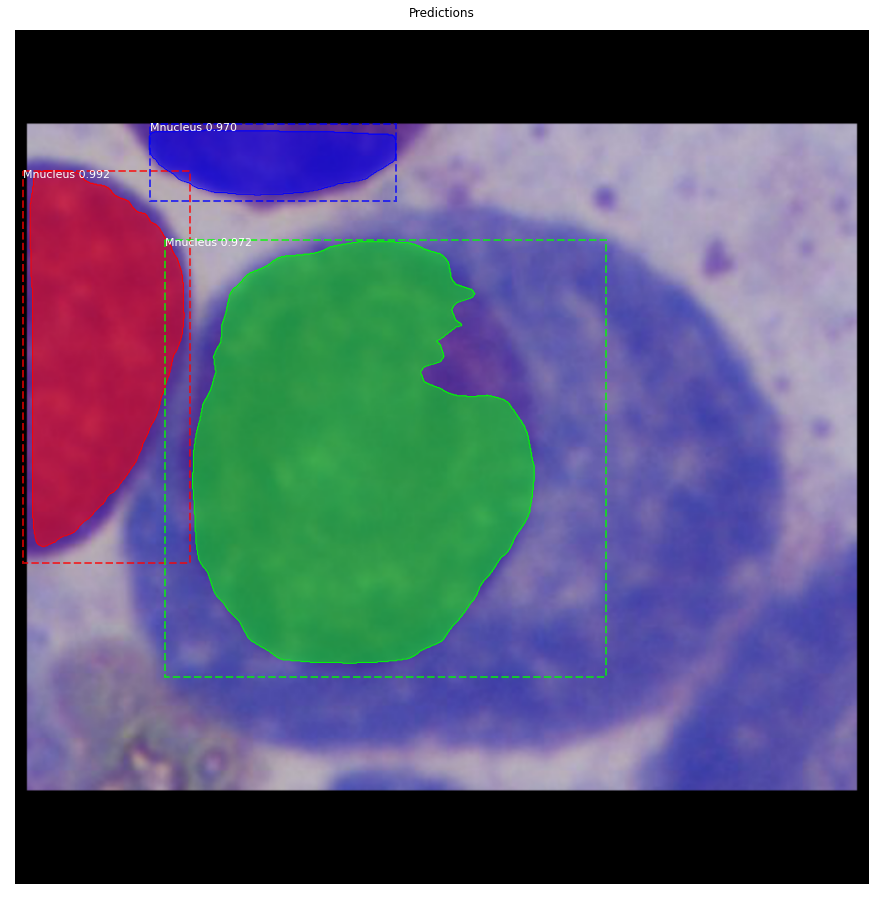

In [ ]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

Color Splash

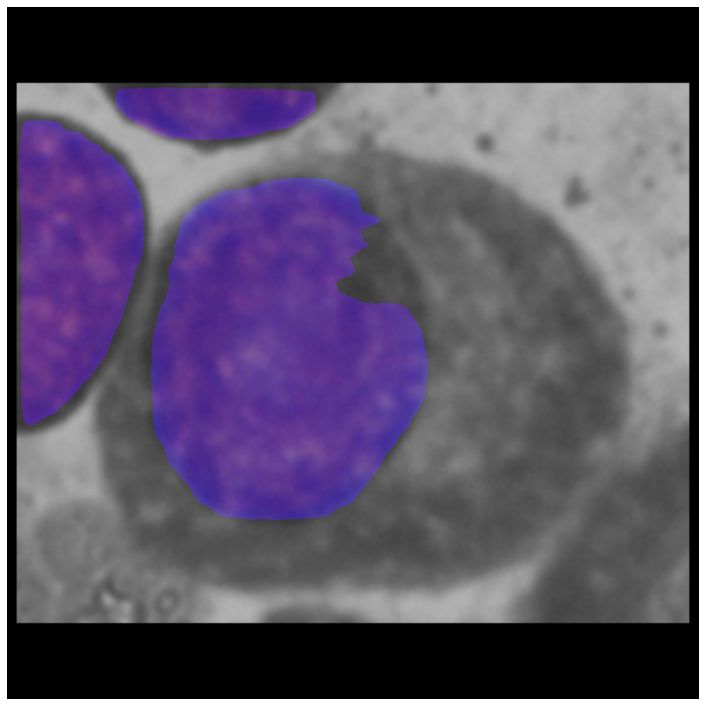

In [ ]:
splash = Mnucleus.color_splash(image, r['masks'])
display_images([splash], cols=1)

Run on whole Myeloma Image

In [ ]:
# Load validation dataset
dataset = Mnucleus.MnucleusDataset()
dataset.load_Mnucleus("/content/drive/MyDrive/Mask_RCNN/samples/myeloma/dataset", "train")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 65
Classes: ['BG', 'Mnucleus']


image ID: Mnucleus.16.jpg (15) /content/drive/MyDrive/Mask_RCNN/samples/myeloma/dataset/train/16.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  251.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  127.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (5,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (5, 4)                min:   77.00000  max:  737.00000  int32
gt_mask                  shape: (1024, 1024, 5)       min:    0.00000  max:    1.00000  bool


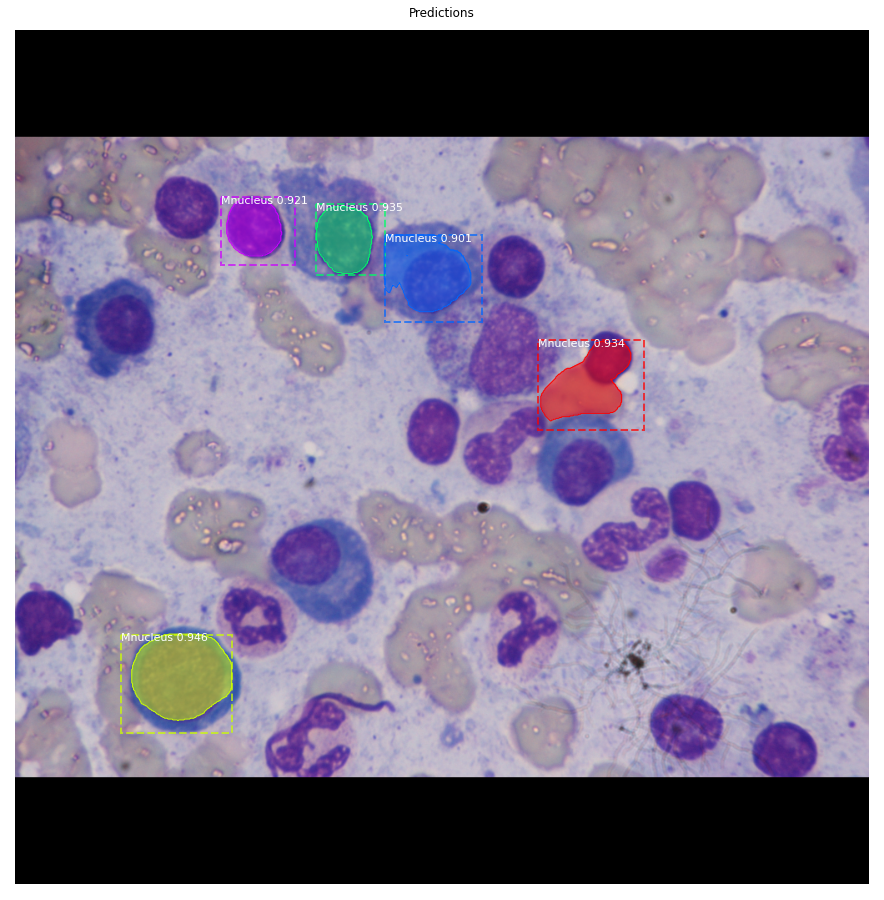

In [ ]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

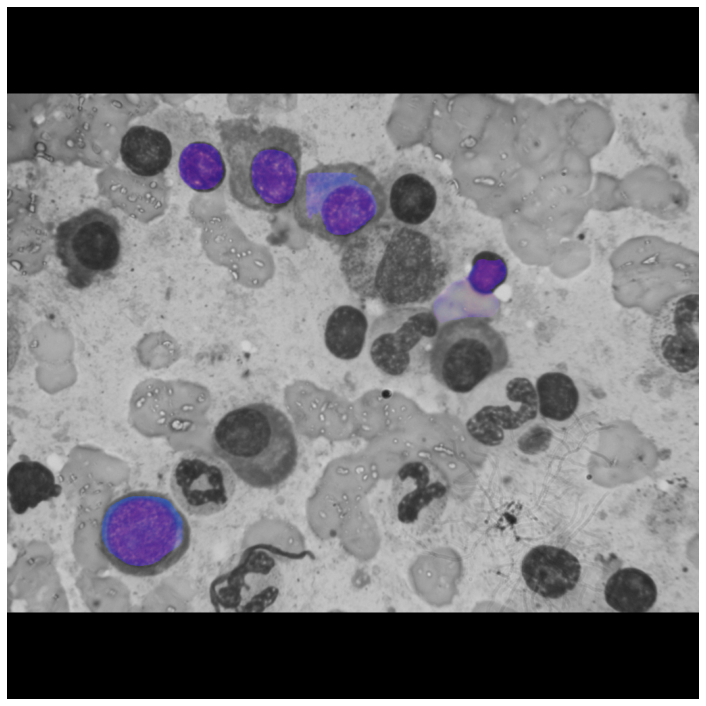

In [ ]:
splash = Mnucleus.color_splash(image, r['masks'])
display_images([splash], cols=1)

Detect on Non Myeloma

In [ ]:
# Load validation dataset
dataset = Mnucleus.MnucleusDataset()
dataset.load_Mnucleus("/content/drive/MyDrive/Mask_RCNN/samples", "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 10
Classes: ['BG', 'Mnucleus']


In [ ]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

IndexError: ignored

Model Weights

In [ ]:
# Show stats of all trainable weights    
visualize.display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
conv1/kernel:0,"(7, 7, 3, 64)",-0.8616,+0.8451,+0.1315
conv1/bias:0,"(64,)",-0.0002,+0.0004,+0.0001
bn_conv1/gamma:0,"(64,)",+0.0835,+2.6411,+0.5091
bn_conv1/beta:0,"(64,)",-2.3931,+5.3610,+1.9781
bn_conv1/moving_mean:0,"(64,)",-173.0470,+116.3013,+44.5654
bn_conv1/moving_variance:0*** Overflow?,"(64,)",+0.0000,+146335.3594,+21847.9668
res2a_branch2a/kernel:0,"(1, 1, 64, 64)",-0.6574,+0.3179,+0.0764
res2a_branch2a/bias:0,"(64,)",-0.0022,+0.0082,+0.0018
bn2a_branch2a/gamma:0,"(64,)",+0.2169,+1.8489,+0.4116
bn2a_branch2a/beta:0,"(64,)",-2.1180,+3.7332,+1.1786


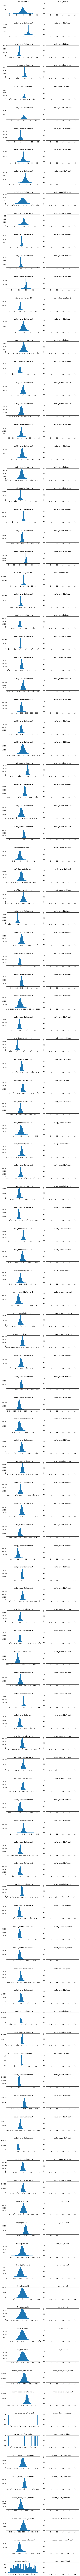

In [ ]:
#histogram of weights

# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.get_trainable_layers()
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 50)